In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import sys
#sys.path.insert(0,"../src/")

from FrankeFunction import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
import unit_tests

%matplotlib inline

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

# Problem 1a)

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 300 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

In [4]:


# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD(X_train, z_train)
        
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)

        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)

        #var_b.append([deg, var_beta(z_train, X_train)])
        
    return mse, r2, 0#, var_b

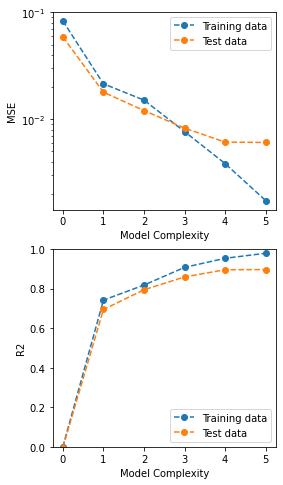

In [5]:
degrees = np.arange(0, 6) # Degrees of the polynomial

# Generate data
MSE_clean, R2_clean, var_b_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)

plt.figure(figsize=(4,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

How does the model respond to noise?

[]

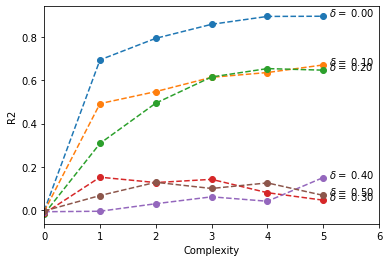

In [6]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, var_b_noisy = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .1,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1])
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.plot()

# Problem 1b)
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

In [28]:
def p2_analysis(x, y, z, degrees, N_bootstraps):
    
    columns = [
        "MSE train",
        "MSE test",
        "R2 train",
        "R2 test",
        "Bias train",
        "Bias test",
        "Variance train",
        "Variance test",
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])
        
        output = bootstrap(
            X_train, 
            X_test, 
            z_train, 
            z_test,
            bootstraps = N_bootstraps,
            regression = linear_regression.OLS_SVD
        )

        df = df.append(pd.DataFrame(output, index=[deg]))
    
    return df

In [29]:
degrees = np.arange(1, 20) # This stop working for 12< possible bug in OLS_SVD?
N_bootstraps = 100
data_bootstrap = p2_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)

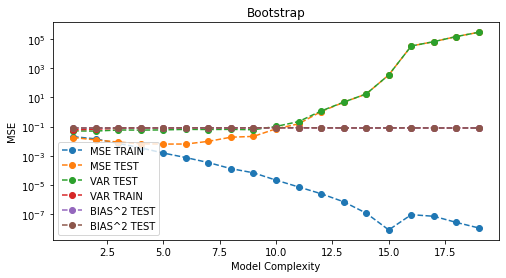

In [41]:
plt.figure(figsize=(8,4))

plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "MSE TRAIN")
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST")
plt.semilogy(degrees, data_bootstrap["Variance train"],"o--", label = "VAR TRAIN")
plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS^2 TEST")
plt.semilogy(degrees, data_bootstrap["Bias train"],"o--", label = "BIAS^2 TEST")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Bootstrap")
plt.legend(loc="lower left")

In [42]:
data_bootstrap

,MSE train,MSE test,R2 train,R2 test,Bias train,Bias test,Variance train,Variance test
1,2.091174e-02,0.018131,0.739762,4.851404e-01,0.081010,0.081010,0.060397,0.051366
2,1.461117e-02,0.012406,0.819168,6.477099e-01,0.081650,0.081650,0.067369,0.049951
3,7.218475e-03,0.008864,0.912326,7.482968e-01,0.083184,0.083184,0.076256,0.059363
4,3.578282e-03,0.006775,0.956526,8.076303e-01,0.083757,0.083757,0.080533,0.058375
5,1.572011e-03,0.006455,0.980445,8.166954e-01,0.081474,0.081474,0.080247,0.059980
6,7.727777e-04,0.006506,0.990618,8.152560e-01,0.083571,0.083571,0.083227,0.065476
7,3.516251e-04,0.009914,0.995652,7.184724e-01,0.082637,0.082637,0.082821,0.063885
8,1.352619e-04,0.019043,0.998319,4.592641e-01,0.082475,0.082475,0.082984,0.065479
9,7.011862e-05,0.021634,0.999140,3.856838e-01,0.083475,0.083475,0.083905,0.061559
10,2.211106e-05,0.071404,0.999729,-1.027590e+00,0.084158,0.084158,0.084707,0.103626


# Problem 1c)
- Do cross validation on the dataset. Compare MSE with bootstrap

In [11]:
def p3_analysis(x, y, z, degrees, k):
    
    columns = [
        "MSE train", "MSE test",
        "R2 train", "R2 test"
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
    
        # Normalize the design matrix
        X = scaler.fit_transform(X)
        X[:, 0] = np.ones(X.shape[0])
        
        output = cross_validation(X, z, k_folds = k, regression=linear_regression.OLS_SVD)
        
        df = df.append(pd.DataFrame(output, index=[deg]))
        
        
    return df

In [12]:
degrees = np.arange(1, 16)
dat_cross = p3_analysis(x_dat, y_dat, z_dat, degrees, k=55)

dat_cross

,MSE train,MSE test,R2 train,R2 test
1,0.020738,0.022010,0.735101,0.304773
2,0.014262,0.015100,0.817819,0.609655
3,0.007411,0.008266,0.905324,0.776263
4,0.003732,0.004144,0.952321,0.884601
5,0.001664,0.002191,0.978741,0.943045
6,0.000863,0.001293,0.988971,0.929789
7,0.000435,0.000686,0.994446,0.976614
8,0.000188,0.000416,0.997597,0.984266
9,0.000124,0.000406,0.998419,0.987722
10,0.000052,0.000277,0.999332,0.993101


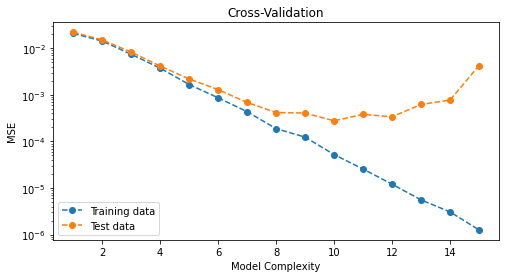

In [13]:
plt.figure(figsize=(8,4))

plt.semilogy(degrees, dat_cross["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, dat_cross["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

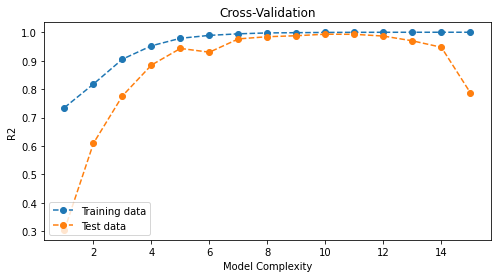

In [14]:
plt.figure(figsize=(8,4))

plt.plot(degrees, dat_cross["R2 train"],"o--", label = "Training data")
plt.plot(degrees, dat_cross["R2 test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

# Problem 1d)
- Do same analysis, but with Ridge regression

# Problem 1e)
- Do Same analysis, but with Lasso Regression

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [15]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i